| Method                 | Order | A-stable? | Symmetric? | Symplectic? | Algebraic stability? | Key Features |
|------------------------|-------|-----------|------------|-------------|-----------------------|--------------|
| Explicit Euler         | 1     | ❌ No      | ❌ No       | ❌ No        | ❌ No                 | Simplest explicit method |
| Classical RK4          | 4     | ❌ No      | ❌ No       | ❌ No        | ❌ No                 | High accuracy but not A-stable |
| Implicit Midpoint      | 2     | ✅ Yes     | ✅ Yes      | ✅ Yes       | ✅ Yes                | Good for stiff and Hamiltonian systems |
| 3-stage Gauss–Legendre | 6     | ✅ Yes     | ✅ Yes      | ✅ Yes       | ✅ Yes                | Implicit RK from Gauss–Legendre collocation; 3 stages achieve 6th order |


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import math

In [3]:
plt.rcParams.update({
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'font.size': 14
})


## The Duffing equation:
### Formula:
$
\ddot{x} + \gamma \dot{x} + \alpha x + \beta x^3 = \delta \cos(\omega t)
$  
  
Convert to first-order system with $x_1 = x$, $x_2 = \dot{x}$:  
  
$
\dot{x}_1 = x_2,\quad
\dot{x}_2 = -\gamma x_2 - \alpha x_1 - \beta x_1^3 + \delta \cos(\omega t)
$

### Aim:
Give the initial condition and parameters, our aim is to motivate the evolution of displacement & velocity.

In [4]:
def f(
        x10: float = 1, 
        x20: float = 0, 
        alpha: float = -1.0, 
        beta: float = 1, 
        gamma: float = 0.02, 
        delta: float = 3, 
        omega: float = 1, 
        time: float = 0.1):
        
    # return the 1-order derivative of x1 and x2
    x1_prime = x20
    x2_prime = - gamma * x20 - alpha * x10 - beta * x10 ** 3 + delta * np.cos(omega * time)

    return x1_prime, x2_prime

  
## Euler's method

Euler update at each step $n \to n+1$ with step size $dt$:  
  
$
x_{1, n+1} = x_{1, n} + dt \cdot x_{2, n}
$    
  
$
x_{2, n+1} = x_{2, n} + dt \cdot \left(-\gamma x_{2, n} - \alpha x_{1, n} - \beta (x_{1, n})^3 + \delta \cos(\omega t_{n})\right)
$  

In [5]:
def Euler(
        x10: float = 1, 
        x20: float = 0, 
        alpha: float = -1.0, 
        beta: float = 1, 
        gamma: float = 0.02, 
        delta: float = 3, 
        omega: float = 1, 
        h: float = 0.1,
        time: float = 0.1):
    
    x1_prime, x2_prime = f(x10, x20, alpha, beta, gamma, delta, omega, time)

    x1 = x10 + h * x1_prime
    x2 = x20 + h * x2_prime
    
    return x1, x2

## Explicit RK4
  
Let the state vector:
  
$\mathbf{X} = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}$  
  
  
The differential equation:
  
$\dot{\mathbf{X}} = f(t, \mathbf{X})$  
  
  
RK4 updates as：
  
$\mathbf{X}_{n+1} = \mathbf{X}_n + \frac{dt}{6}(k_1 + 2k_2 + 2k_3 + k_4)$
  
  
with 
  
$k_1 = f(t_n, \mathbf{X}_n)$  
  
  
$k_2 = f\Big(t_n + \tfrac{dt}{2}, \mathbf{X}_n + \tfrac{dt}{2}k_1\Big)$
  
  
$k_3 = f\Big(t_n + \tfrac{dt}{2}, \mathbf{X}_n + \tfrac{dt}{2}k_2\Big)$
  
  
$k_4 = f(t_n + dt, \mathbf{X}_n + dt \cdot k_3)$
  


In [6]:
def RK4(
        x10: float = 1, 
        x20: float = 0, 
        alpha: float = -1.0, 
        beta: float = 1, 
        gamma: float = 0.02, 
        delta: float = 3, 
        omega: float = 1, 
        h: float = 0.1,
        time: float = 0.1):
    
    k1_x1, k1_x2 = f(x10, x20, alpha, beta, gamma, delta, omega, time)
    
    k2_x1, k2_x2 = f(
        x10 + 0.5 * h * k1_x1,
        x20 + 0.5 * h * k1_x2,
        alpha, beta, gamma, delta, omega,
        time + h / 2
    )
    
    k3_x1, k3_x2 = f(
        x10 + 0.5 * h * k2_x1,
        x20 + 0.5 * h * k2_x2,
        alpha, beta, gamma, delta, omega,
        time + h / 2
    )
    
    k4_x1, k4_x2 = f(
        x10 + h * k3_x1,
        x20 + h * k3_x2,
        alpha, beta, gamma, delta, omega,
        time + h
    )
    
    x1 = x10 + (h / 6) * (k1_x1 + 2 * k2_x1 + 2 * k3_x1 + k4_x1)
    x2 = x20 + (h / 6) * (k1_x2 + 2 * k2_x2 + 2 * k3_x2 + k4_x2)
    
    return x1, x2

# Implicit midpoint (Gauss–Legendre 1-stage)
formula: $X = X_n + h \, f\!\left(t_n + \tfrac{h}{2}, \tfrac{X_n + X}{2}\right)$  
  
Procedures:

1. Define the residual function, which is our optimization aim  
  
    $  
    G(X) = X - X_n - h\,f\!\Big(t_n+\tfrac{h}{2},\,\tfrac{X_n+X}{2}\Big).
    $  
    
    Our goal is to find a $X$ such that $G(X)=0$.  
    And we use Newton's method to do that (Cause Duffing equation does not have analytical solution, we can only appromation. And Duffing equation is stiff, so functional iteration doesn't work, we need to use Newton's method).
    
2. Newton's Method:
   - At iterate $X^{(k)}$, linearize  
       
     $
     G(X^{(k)}+s) \approx G(X^{(k)}) + J\,s,
     $  
       
     through Taylor's expansion and setting $G(X^{(k)}+s)=0$, where $J=\partial G/\partial X$ is the Jacobian evaluated at $X^{(k)}$.
   - Solve the linear system 
     $
     J\,s = -G(X^{(k)}),
     $
     then update $X^{(k+1)}=X^{(k)}+s$.
   - Repeat until $\|s\|$ small.

3. Jacobian for the Duffing system:
   - For $X=[x_1,x_2]^T$ and  
       
     $
     f(t,X)=\begin{pmatrix} x_2 \\ -\gamma x_2 -\alpha x_1 -\beta x_1^3 + \delta\cos(\omega t)\end{pmatrix},
     $  
       
     the derivative of $f$, written as $D_f$, at the midpoint $X_{\mathrm{mid}}=(X_n+X)/2$ is  
       
     $
     D_f=\begin{pmatrix}0 & 1\\[4pt] -(\alpha+3\beta x_{1,\mathrm{mid}}^2) & -\gamma \end{pmatrix}.
     $
       
   - Then
     $$
     J = dG/dX = I − h · (dX_{\mathrm{mid}}/dX) · (∂f/∂X_{\mathrm{mid}} at X_{\mathrm{mid}}) = I - \frac{h}{2} D_f
     =
     \begin{pmatrix}
     1 & -\tfrac{h}{2}\\[6pt]
     \tfrac{h}{2}(\alpha+3\beta x_{1,\mathrm{mid}}^2) & 1+\tfrac{h}{2}\gamma
     \end{pmatrix}.
     $$  
     Use it to iterate through Newton's method.

In [7]:
def midpoint(
        x10: float = 1, 
        x20: float = 0, 
        alpha: float = -1.0, 
        beta: float = 1, 
        gamma: float = 0.02, 
        delta: float = 3, 
        omega: float = 1, 
        h: float = 0.1,
        time: float = 0.1,
        max_iteration: int = 30,
        tol: float = 1e-9
        ):
    
    # To start Newton's method, we first set a initial value to X (our aim) for iteration
    # Set the initial value by explicit Euler's method
    x1, x2 = Euler(x10, x20, alpha, beta, gamma, delta, omega, h, time)
    X = np.array([x1, x2], dtype=float)
    X0 = np.array([x10, x20], dtype=float)
    
    for _ in range(max_iteration):
        m = (X + X0) / 2
        G = X - X0 - h * np.array(f(m[0], m[1], alpha, beta, gamma, delta, omega, time + 0.5 * h), dtype=float)
        # the Jacobian of f w.r.t. m
        Df = np.array([[0.0, 1.0],
                       [-(alpha + 3.0 * beta * m[0]**2), -gamma]],
                      dtype=float)
        # the Jacobian of G w.r.t. X
        J = np.eye(2) - 0.5 * h * Df
        
        if np.allclose(J, np.zeros((2, 2))):  # if the Jacobian becomes to zero
            return X[0], X[1]

        # catch LinAlgError
        try:
            s = np.linalg.solve(J, -G)
        except np.linalg.LinAlgError:
            lin_alg_error = True
            print("MidPoint: lin_alg_error occurs")
            raise 

        # catch diverge
        if (not np.isfinite(s).all()) or np.linalg.norm(s) > 1e6:
            diverged = True
            print("GL3: diverged")

        X = X + s

        if np.linalg.norm(s, ord=2) < tol or np.linalg.norm(G, ord=2) < tol:
            break

    return X[0], X[1]

# 3-Stage Gauss-Legendre

- Similar idea to **Implicit Midpoint**. Our aim is to construct the residual function $G$, and utilize $J s = -G$ to iterate.
- The difference is that, we now have 3 stages (time nodes) between $[time, time + h]$. Therefore, we need to give all three of them initial values, and RK4 is adopted here. Moreover, when contructing $G$, it should be the function of all three stages.
### Details:
1. In 3-stage GL, every stage satisfies that:  
      
    $X_i = y_n + h \sum_{j=1}^3 A_{ij}\, f(t_n+c_j h, X_j), \quad i=1,2,3.$  
      
2. The residual function is:  
      
    $G_i(X) := X_i - y_n - h \sum_{j=1}^3 A_{ij}\, f(t_n+c_j h, X_j).$  with $G=(G_1,G_2,G_3)$, and $G_i\in\mathbb{R}^2$
      
    Our aim is find the solution to make it to be zero.

3. The partial derivate of $G$ w.r.t. $X_j$, $j=1,2,3$, is 
      
    $\frac{\partial G_i}{\partial X_j} = \delta_{ij} I_2 - h A_{ij} f_y(t_j,X_j)$   
      
    with $\delta_{ij}$ the Kronecker delta, $\delta_{ij} =\begin{cases} 1, & i=j,\\0, & i\neq j.\end{cases}$

4. Thus, the Jacobian of $G$ is:
      
      $$J = 
        \begin{bmatrix}
        I_2 - h A_{11} f(X_1) & -h A_{12} f(X_2) & -h A_{13} f(X_3) \\
        -h A_{21} f(X_1) & I_2 - h A_{22} f(X_2) & -h A_{23} f(X_3) \\
        -h A_{31} f(X_1) & -h A_{32} f(X_2) & I_2 - h A_{33} f(X_3)
        \end{bmatrix}.
      $$


In [8]:
def GL3stage(
        x10: float = 1, 
        x20: float = 0, 
        alpha: float = -1.0, 
        beta: float = 1, 
        gamma: float = 0.02, 
        delta: float = 3, 
        omega: float = 1, 
        h: float = 0.1,
        time: float = 0.1,
        max_iteration: int = 100,
        tol: float = 1e-9
        ):

    sqrt15 = np.sqrt(15.0)
    A = np.array([
        [5/36, 2/9 - sqrt15/15, 5/36 - sqrt15/30],
        [5/36 + sqrt15/24, 2/9, 5/36 - sqrt15/24],
        [5/36 + sqrt15/30, 2/9 + sqrt15/15, 5/36]
    ], dtype=float)  # based on the Butcher Tableau
    b = np.array([5/18, 4/9, 5/18])
    c = np.array([1/2 - sqrt15/10, 1/2, 1/2 + sqrt15/10])

    # 
    def Df(x1):
        return np.array([[0.0, 1.0],
                [-(alpha + 3.0 * beta * x1**2), -gamma]],
                dtype=float)

    X0 = np.array([x10, x20])
    X = np.zeros((3, 2))

    # use RK4 to assign initial values for X
    for i in range(3):
        X[i] = RK4(x10, x20, alpha, beta, gamma, delta, omega, c[i]*h, time)
    
    for _ in range(max_iteration):

        # calculate J
        f_block = np.zeros((3, 2), dtype=float)
        for j in range(3):
            f_block[j] = np.array(
                f(X[j, 0], X[j, 1], alpha, beta, gamma, delta, omega, time + c[j] * h),
                dtype=float
            )
        J = np.zeros((6, 6), dtype=float)
        I2 = np.eye(2)
        for i in range(3):
            for j in range(3):
                Df_j = Df(X[j, 0])
                block = (I2 if i == j else np.zeros((2, 2))) - h * A[i, j] * Df_j
                J[2*i:2*i+2, 2*j:2*j+2] = block

        # Calculate G
        G = np.zeros((3, 2), dtype=float)
        for i in range(3):
            s = np.zeros(2, dtype=float)
            for j in range(3):
                s += A[i, j] * f_block[j]
            G[i] = X[i] - X0 - h * s
        
        G_vec = G.ravel()  # 3 × 2 -> 6
        try:
            s_vec = np.linalg.solve(J, -G_vec)
        except np.linalg.LinAlgError:
            raise RuntimeError("GL3stage: Jacobian singular")

        X_flat = X.ravel() + s_vec
        X = X_flat.reshape(3, 2)

        if np.linalg.norm(s_vec, ord=2) < tol or np.linalg.norm(G_vec, ord=2) < tol:
            break
    
    # calculate the final result
    sum_bf = np.zeros(2, dtype=float)
    for j in range(3):
        fj = np.array(
            f(X[j, 0], X[j, 1], alpha, beta, gamma, delta, omega, time + c[j] * h),
            dtype=float
        )
        sum_bf += b[j] * fj
    X_next = X0 + h * sum_bf

    return X_next[0], X_next[1]

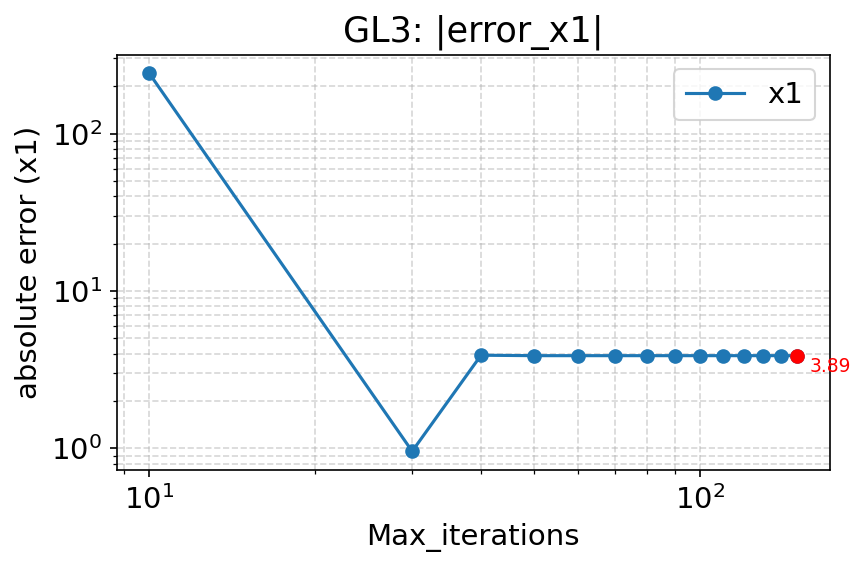

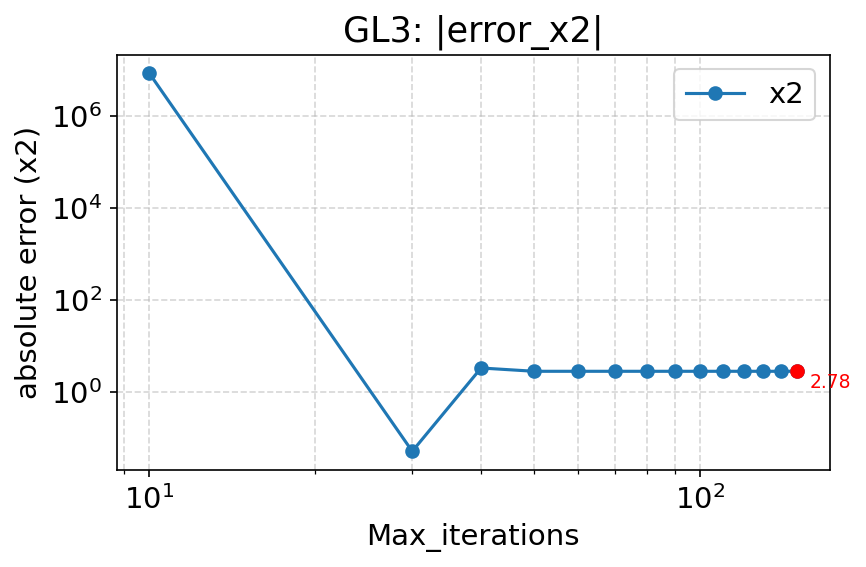

In [9]:
ref = np.array([1.86896745, 1.83346824])
h = 10
x10, x20 = 0.7, 0.2
# x10, x20 = 1.0, 0.0
# alpha, beta, gamma, delta, omega = -1.0, 1.0, 0.02, 3, 1.0
alpha, beta, gamma, delta, omega = -1.0, 1.0, 0, 0, 1.0
time = 0.0
x1, x2 = x10, x20

errors = {"x1": [], "x2": []}
max_iters = [10, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
for max_iter in max_iters:
    for _ in range(int(20/h)):
        x1, x2 = GL3stage(x10, x20, alpha, beta, gamma, delta, omega, h, time, max_iteration=max_iter)
    
    abs_err = np.abs(np.array([x1, x2]) - ref)
    errors["x1"].append(float(abs_err[0]))
    errors["x2"].append(float(abs_err[1]))


plt.figure(figsize=(6,4))
plt.loglog(max_iters, errors["x1"], '-o', label=f"x1")
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.xlabel('Max_iterations'); plt.ylabel('absolute error (x1)'); plt.legend(); plt.title('GL3: |error_x1|')
x_last = float(max_iters[-1])
y_last = float(errors["x1"][-1])
plt.scatter([x_last], [y_last], color='red', zorder=10)
plt.annotate(f"{y_last:.3g}", xy=(x_last, y_last),
                xytext=(6, -8), textcoords='offset points', color='red', fontsize=9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.loglog(max_iters, errors["x2"], '-o', label=f"x2")
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.xlabel('Max_iterations'); plt.ylabel('absolute error (x2)'); plt.legend(); plt.title('GL3: |error_x2|')
x_last = float(max_iters[-1])
y_last = float(errors["x2"][-1])
plt.scatter([x_last], [y_last], color='red', zorder=10)
plt.annotate(f"{y_last:.3g}", xy=(x_last, y_last),
                xytext=(6, -8), textcoords='offset points', color='red', fontsize=9)
plt.tight_layout()
plt.show()

In [10]:
x10, x20 = 0.7, 0.2
# x10, x20 = 1.0, 0.0
# alpha, beta, gamma, delta, omega = -1.0, 1.0, 0.02, 3, 1.0
alpha, beta, gamma, delta, omega = -1.0, 1.0, 0, 0, 1.0
h = 0.01
time = 0.0  # t_n

In [11]:
# convergence analysis
def integrate_method(method, x0, t0, h, n_steps, **params):
    x1, x2 = x0
    t = t0
    call_params = {k: v for k, v in params.items() if k != 'time'}
    for _ in range(n_steps):
        x1, x2 = method(x1, x2, **call_params, h=h, time=t)
        t += h
    return np.array([x1, x2])

T = 20.0
t0 = 0.0
x0 = (x10, x20)
h_list = (10.0 * 0.5**np.arange(0, 14))[::-1]  # increasing: [~0.0012207, ..., 10], 14 choices
methods = {
    'Euler': Euler,
    'RK4'  : RK4,
    'Midpoint': midpoint,
    'GL3'  : GL3stage
}
params = dict(alpha=alpha, beta=beta, gamma=gamma, delta=delta, omega=omega, time=t0)

h_ref = 1e-4
n_ref = int(T / h_ref)
ref = integrate_method(GL3stage, x0, t0, h_ref, n_ref, **params)
print(f"ref is {ref}")

errors = {name: {"x1": [], "x2": []} for name in methods}
for h in h_list:
    n = int(T / h)
    for name, meth in methods.items():
        sol = integrate_method(meth, x0, t0, h, n, **params)  # sol is array([x1, x2])
        abs_err = np.abs(sol - ref)                          # elementwise absolute error
        errors[name]["x1"].append(float(abs_err[0]))
        errors[name]["x2"].append(float(abs_err[1]))

# print errors and the estimated orders (from log-log fit) separately for x1 and x2
for name in methods:
    hs = np.array(h_list)
    ex1 = np.array(errors[name]["x1"])
    ex2 = np.array(errors[name]["x2"])

    mask1 = np.isfinite(ex1) & (ex1 > 0)
    mask2 = np.isfinite(ex2) & (ex2 > 0)

    if mask1.sum() >= 2:
        p1, _ = np.polyfit(np.log(hs[mask1]), np.log(ex1[mask1]), 1)
        order_x1 = p1
    else:
        order_x1 = float('nan')

    if mask2.sum() >= 2:
        p2, _ = np.polyfit(np.log(hs[mask2]), np.log(ex2[mask2]), 1)
        order_x2 = p2
    else:
        order_x2 = float('nan')

    print(f"{'Step':>4s} | {'x1 error':>12s} | {'x2 error':>12s}")
    print("-" * 36)
    for i, (e1, e2) in enumerate(zip(ex1, ex2)):
        print(f"{i:4d} | {e1:12.6e} | {e2:12.6e}")
    print(f"\nObserved orders: x1 ≈ {order_x1:.3f}, x2 ≈ {order_x2:.3f}")

ref is [0.96467695 0.409441  ]


C:\Windows\Temp\ipykernel_23824\1639351232.py:13: RuntimeWarning: overflow encountered in scalar power
  x2_prime = - gamma * x20 - alpha * x10 - beta * x10 ** 3 + delta * np.cos(omega * time)
C:\Windows\Temp\ipykernel_23824\1639351232.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  x2_prime = - gamma * x20 - alpha * x10 - beta * x10 ** 3 + delta * np.cos(omega * time)


Step |     x1 error |     x2 error
------------------------------------
   0 | 2.129666e-02 | 4.616913e-03
   1 | 4.421113e-02 | 7.149197e-03
   2 | 9.485853e-02 | 5.106495e-03
   3 | 2.139235e-01 | 3.211325e-02
   4 | 4.881404e-01 | 2.429354e-01
   5 | 3.713323e-01 | 1.027274e+00
   6 | 2.317454e+00 | 1.632719e+00
   7 |          nan |          nan
   8 |          nan |          nan
   9 |          nan |          nan
  10 |          nan |          nan
  11 | 1.277673e+26 | 4.133587e+29
  12 | 3.911476e+04 | 1.007086e+06
  13 | 3.943532e+01 | 1.664694e+02

Observed orders: x1 ≈ 3.343, x2 ≈ 4.117
Step |     x1 error |     x2 error
------------------------------------
   0 | 5.482281e-13 | 1.143530e-13
   1 | 9.969914e-12 | 1.618650e-12
   2 | 1.586881e-10 | 2.626382e-11
   3 | 2.472207e-09 | 4.375482e-10
   4 | 3.737792e-08 | 7.558814e-09
   5 | 5.279377e-07 | 1.387133e-07
   6 | 6.182912e-06 | 2.781186e-06
   7 | 2.581309e-05 | 6.186804e-05
   8 | 1.857821e-03 | 1.493136e-03
   9 | 6.8

C:\Windows\Temp\ipykernel_23824\707720767.py:41: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(0, 1e9)


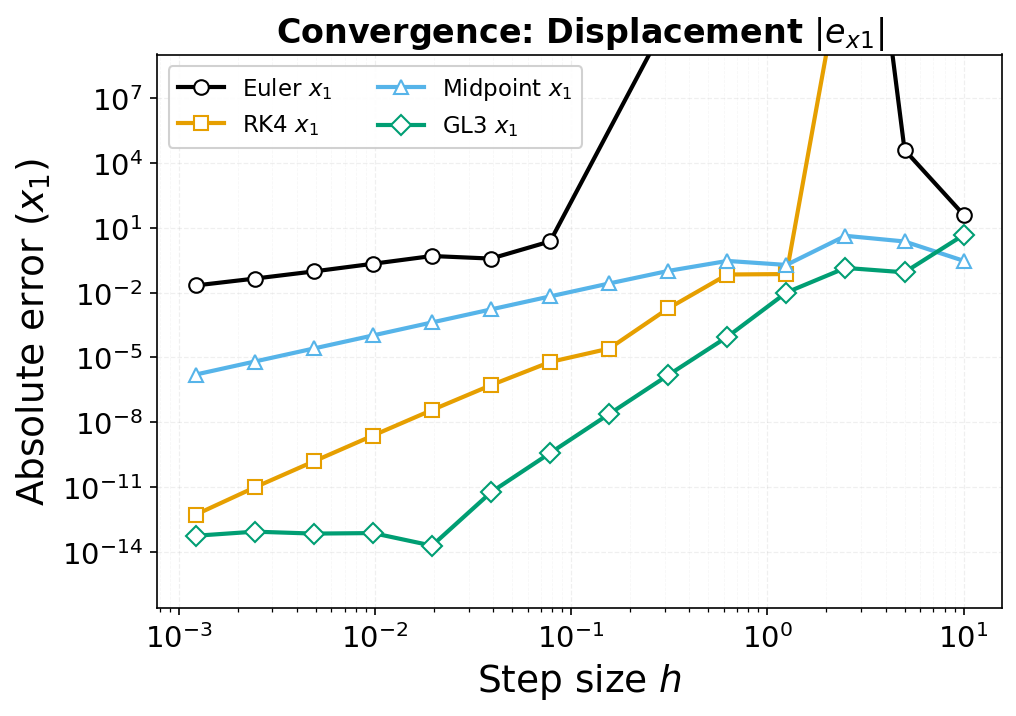

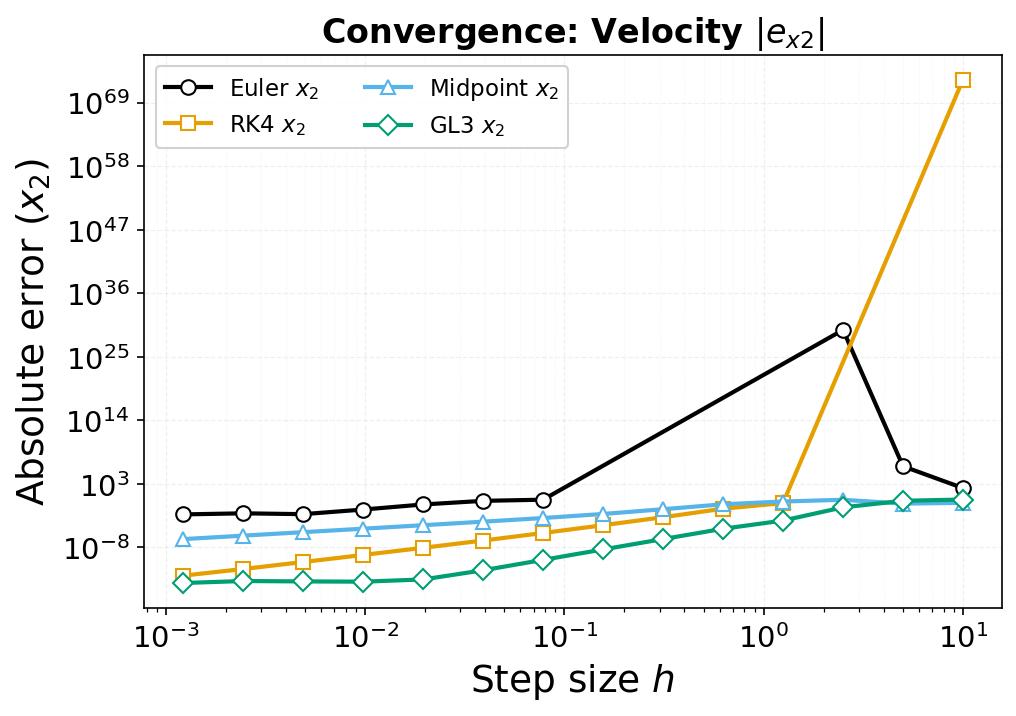

In [24]:
def _to_1d(a):
    a = np.asarray(a)
    a = np.squeeze(a)
    if a.ndim > 1:
        a = a.ravel()
    return a

def loglog_safe(ax, x, y, *args, **kwargs):
    x1, y1 = _to_1d(x), _to_1d(y)
    if x1.size != y1.size:
        raise ValueError(f"x and y sizes differ: {x1.size} vs {y1.size}")
    m = np.isfinite(x1) & np.isfinite(y1) & (x1 > 0) & (y1 > 0)  # log–log 需要正数
    if not np.any(m):
        raise ValueError("No finite positive points to plot on log–log.")
    return ax.loglog(x1[m], y1[m], *args, **kwargs)

OI = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#0072B2']
markers = ['o', 's', '^', 'D', 'v', '>', '<', 'P']
linestyles = ['-', '-', '-', '-', (0,(3,1,1,1)), (0,(5,2))]

color_map = {name: OI[i % len(OI)] for i, name in enumerate(methods)}
marker_map = {name: markers[i % len(markers)] for i, name in enumerate(methods)}
ls_map     = {name: linestyles[i % len(linestyles)] for i, name in enumerate(methods)}

common = dict(linewidth=2.0, markersize=7, markerfacecolor='white')

# Figure 1: x1 Error
fig1, ax1 = plt.subplots(figsize=(7, 5))
for name in methods:
    lbl = f"{name} $x_1$"
    loglog_safe(ax1, h_list, errors[name]["x1"],
                color=color_map[name], marker=marker_map[name], linestyle=ls_map[name],
                label=lbl, **common)

ax1.grid(True, which='major', alpha=0.2, linestyle='--', linewidth=0.6)
ax1.grid(True, which='minor', alpha=0.1, linestyle='--', linewidth=0.4)
ax1.set_xlabel('Step size $h$', fontsize=18)
ax1.set_ylabel('Absolute error ($x_1$)', fontsize=18)
ax1.set_title('Convergence: Displacement $|e_{x1}|$', fontsize=16, fontweight='bold')
leg1 = ax1.legend(frameon=True, fancybox=True, framealpha=0.9, loc='best', ncol=2, fontsize=11)
ax1.set_ylim(0, 1e9)
plt.tight_layout()
plt.show()

# Figure 2: x2 Error
fig2, ax2 = plt.subplots(figsize=(7, 5))
for name in methods:
    lbl = f"{name} $x_2$"
    loglog_safe(ax2, h_list, errors[name]["x2"],
                color=color_map[name], marker=marker_map[name], linestyle=ls_map[name],
                label=lbl, **common)

ax2.grid(True, which='major', alpha=0.2, linestyle='--', linewidth=0.6)
ax2.grid(True, which='minor', alpha=0.1, linestyle='--', linewidth=0.4)
ax2.set_xlabel('Step size $h$', fontsize=18)
ax2.set_ylabel('Absolute error ($x_2$)', fontsize=18)
ax2.set_title('Convergence: Velocity $|e_{x2}|$', fontsize=16, fontweight='bold')
leg2 = ax2.legend(frameon=True, fancybox=True, framealpha=0.9, loc='best', ncol=2, fontsize=11)
plt.tight_layout()
plt.show()

In [25]:
x10, x20 = 0.7, 0.2
alpha, beta, gamma, delta, omega = -1.0, 1.0, 0, 0, 1.0
h = 0.01
time = 0.0

C:\Windows\Temp\ipykernel_23824\1639351232.py:13: RuntimeWarning: overflow encountered in scalar power
  x2_prime = - gamma * x20 - alpha * x10 - beta * x10 ** 3 + delta * np.cos(omega * time)
C:\Windows\Temp\ipykernel_23824\1639351232.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  x2_prime = - gamma * x20 - alpha * x10 - beta * x10 ** 3 + delta * np.cos(omega * time)


After 200 steps (h=0.2, T=40.0):


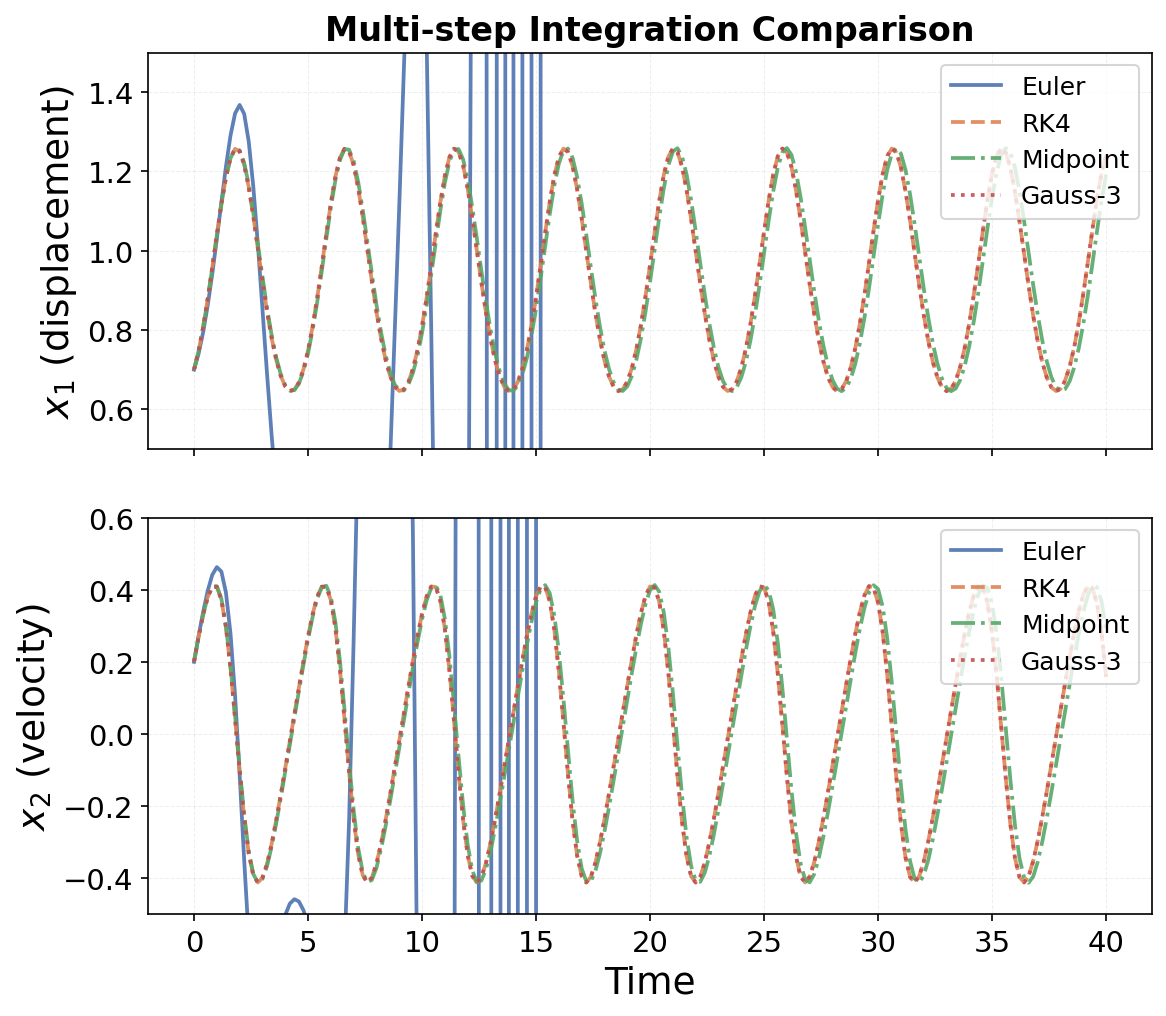

In [26]:
# Multi-step comparison
total_time = 40.0
h = 0.2
n_steps = int(total_time / h)
times = np.linspace(0.0, n_steps * h, n_steps + 1)

# storage
e_x1s, e_x2s = [x10], [x20]
rk_x1s, rk_x2s = [x10], [x20]
mp_x1s, mp_x2s = [x10], [x20]
gl_x1s, gl_x2s = [x10], [x20]

# integrate
for k in range(n_steps):
    t = times[k]
    # Euler
    ex1, ex2 = Euler(e_x1s[-1], e_x2s[-1],
                     alpha, beta, gamma, delta, omega, h, t)
    e_x1s.append(ex1); e_x2s.append(ex2)

    # RK4
    rx1, rx2 = RK4(rk_x1s[-1], rk_x2s[-1],
                   alpha, beta, gamma, delta, omega, h, t)
    rk_x1s.append(rx1); rk_x2s.append(rx2)

    # Midpoint (implicit) - catch failures
    try:
        mx1, mx2 = midpoint(mp_x1s[-1], mp_x2s[-1],
                             alpha, beta, gamma, delta, omega, h, t)
    except Exception as exc:
        print(f"midpoint failed at step {k}, t={t}: {exc}")
        mx1, mx2 = mp_x1s[-1], mp_x2s[-1]
    mp_x1s.append(mx1); mp_x2s.append(mx2)

    # Gauss-3 (implicit) - catch failures
    try:
        gx1, gx2 = GL3stage(gl_x1s[-1], gl_x2s[-1],
                             alpha, beta, gamma, delta, omega, h, t)
    except Exception as exc:
        print(f"GL3stage failed at step {k}, t={t}: {exc}")
        gx1, gx2 = gl_x1s[-1], gl_x2s[-1]
    gl_x1s.append(gx1); gl_x2s.append(gx2)

# convert to arrays
e_x1s = np.array(e_x1s); e_x2s = np.array(e_x2s)
rk_x1s = np.array(rk_x1s); rk_x2s = np.array(rk_x2s)
mp_x1s = np.array(mp_x1s); mp_x2s = np.array(mp_x2s)
gl_x1s = np.array(gl_x1s); gl_x2s = np.array(gl_x2s)

# print final values
print(f"After {n_steps} steps (h={h}, T={total_time}):")
# print(" Euler   final:", e_x1s[-1], e_x2s[-1])
# print(" RK4     final:", rk_x1s[-1], rk_x2s[-1])
# print(" Midpoint final:", mp_x1s[-1], mp_x2s[-1])
# print(" Gauss-3 final:", gl_x1s[-1], gl_x2s[-1])

# plot
palette = {
    'Euler': '#4C72B0',    # muted blue
    'RK4':   '#DD8452',    # warm orange
    'Midpoint': '#55A868', # green
    'Gauss-3': '#C44E52'   # red
}

fig, axs = plt.subplots(2, 1, figsize=(8, 7), sharex=True)

# displacement
axs[0].plot(times, e_x1s, label='Euler', color=palette['Euler'], linewidth=1.8, alpha=0.9)
axs[0].plot(times, rk_x1s, label='RK4', color=palette['RK4'], linewidth=1.8, linestyle='--', alpha=0.9)
axs[0].plot(times, mp_x1s, label='Midpoint', color=palette['Midpoint'], linewidth=1.8, linestyle='-.', alpha=0.9)
axs[0].plot(times, gl_x1s, label='Gauss-3', color=palette['Gauss-3'], linewidth=1.8, linestyle=':', alpha=0.9)
axs[0].set_ylabel('$x_1$ (displacement)', fontsize=18)
axs[0].legend(frameon=True, loc='upper right', fontsize=12)
axs[0].grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
axs[0].set_title('Multi-step Integration Comparison', fontsize=16, fontweight='bold')

# velocity
axs[1].plot(times, e_x2s, label='Euler', color=palette['Euler'], linewidth=1.8, alpha=0.9)
axs[1].plot(times, rk_x2s, label='RK4', color=palette['RK4'], linewidth=1.8, linestyle='--', alpha=0.9)
axs[1].plot(times, mp_x2s, label='Midpoint', color=palette['Midpoint'], linewidth=1.8, linestyle='-.', alpha=0.9)
axs[1].plot(times, gl_x2s, label='Gauss-3', color=palette['Gauss-3'], linewidth=1.8, linestyle=':', alpha=0.9)
axs[1].set_ylabel('$x_2$ (velocity)', fontsize=18)
axs[1].set_xlabel('Time', fontsize=18)
axs[1].legend(frameon=True, loc='upper right', fontsize=12)
axs[1].grid(True, alpha=0.2, linestyle='--', linewidth=0.5)

plt.tight_layout()
axs[0].set_ylim(0.5, 1.5)
axs[1].set_ylim(-0.5, 0.6)
plt.show()

C:\Windows\Temp\ipykernel_23824\3774608866.py:5: RuntimeWarning: overflow encountered in square
  return 0.5 * v**2 + 0.5 * alpha * x**2 + 0.25 * beta * x**4
C:\Windows\Temp\ipykernel_23824\3774608866.py:5: RuntimeWarning: invalid value encountered in add
  return 0.5 * v**2 + 0.5 * alpha * x**2 + 0.25 * beta * x**4
C:\Windows\Temp\ipykernel_23824\3774608866.py:5: RuntimeWarning: overflow encountered in power
  return 0.5 * v**2 + 0.5 * alpha * x**2 + 0.25 * beta * x**4


Initial energies: E0_e=-0.164975, E0_rk=-0.164975, E0_mp=-0.164975, E0_gl=-0.164975


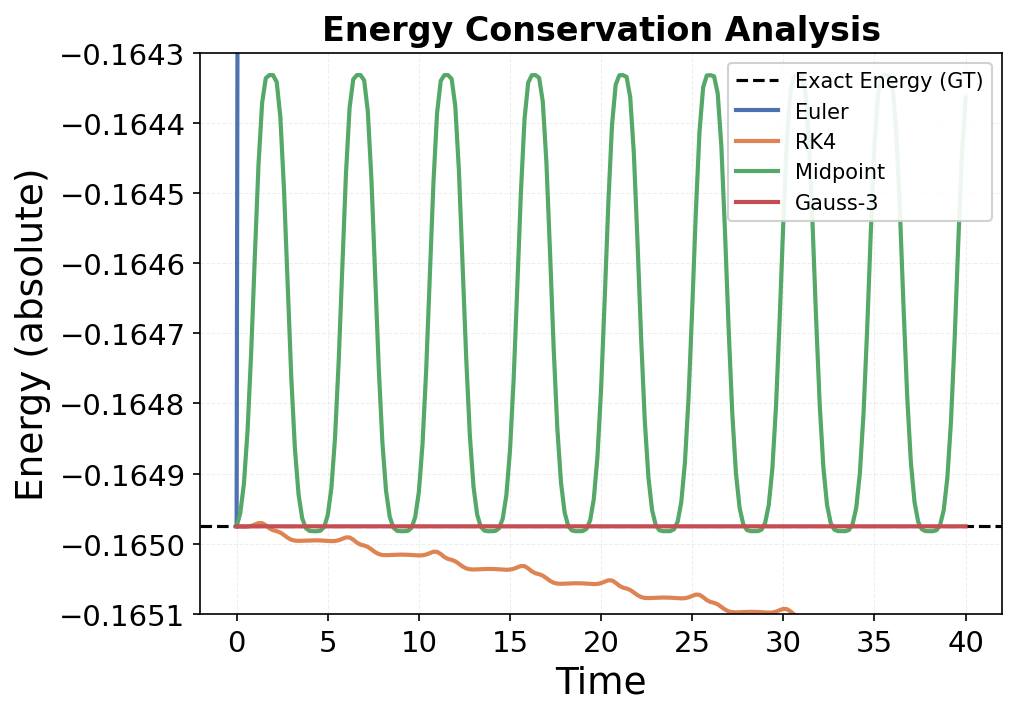

In [27]:
# let's set gamma and sigma as zero, to make the system hamiltonian
# gamma, delta = 0, 0

def energy(x, v, alpha, beta):
    return 0.5 * v**2 + 0.5 * alpha * x**2 + 0.25 * beta * x**4

E_e  = energy(e_x1s, e_x2s, alpha, beta)
E_rk = energy(rk_x1s, rk_x2s, alpha, beta)
E_mp = energy(mp_x1s, mp_x2s, alpha, beta)
E_gl = energy(gl_x1s, gl_x2s, alpha, beta)

# The exact energy (GT) is constant and equal to the initial energy
E_exact = E_e[0] 

print(f"Initial energies: E0_e={E_e[0]:.6g}, E0_rk={E_rk[0]:.6g}, E0_mp={E_mp[0]:.6g}, E0_gl={E_gl[0]:.6g}")

fig, ax = plt.subplots(figsize=(7, 5))

# 1. Ground Truth (Constant Energy)
ax.axhline(E_exact, color='black', linestyle='--', linewidth=1.5, label='Exact Energy (GT)', zorder=0)

# 2. Numerical Trajectories
ax.plot(times, E_e,  label='Euler',    color=palette['Euler'], linewidth=2)
ax.plot(times, E_rk, label='RK4',      color=palette['RK4'], linestyle='-', linewidth=2)
ax.plot(times, E_mp, label='Midpoint', color=palette['Midpoint'], linestyle='-', linewidth=2)
ax.plot(times, E_gl, label='Gauss-3',  color=palette['Gauss-3'], linestyle='-', linewidth=2)

ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Energy (absolute)', fontsize=18)
ax.set_title('Energy Conservation Analysis', fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)

# Setting limits to zoom in on Hamiltonian conservation behavior
ax.set_ylim(-0.1651, -0.1643)

plt.tight_layout()
plt.show()

10 201


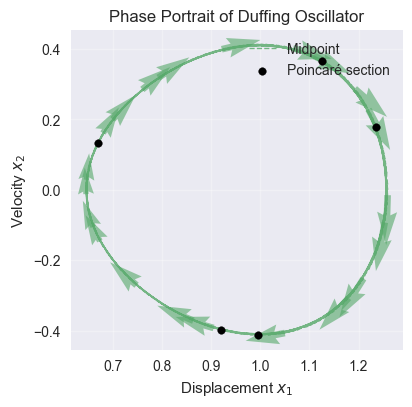

In [ ]:
# 绘制相图 (Phase Portrait): velocity vs displacement
fig, ax = plt.subplots(figsize=(6, 6))

# 1. 绘制轨迹
ax.plot(mp_x1s, mp_x2s, label='Midpoint Trajectory', color='royalblue', linewidth=1.5, alpha=0.9)

# 2. 添加方向箭头 (Quiver plot)
skip = max(1, len(mp_x1s)//20)
dq = np.gradient(mp_x1s)[::skip]
dp = np.gradient(mp_x2s)[::skip]
# Normalize for uniform arrow size
norm = np.sqrt(dq**2 + dp**2)
ax.quiver(mp_x1s[::skip], mp_x2s[::skip], 
          dq/norm, dp/norm,
          angles='xy', scale_units='xy', scale=4, width=0.012, color='royalblue', alpha=0.5)

# 3. Poincaré section
period = 2*np.pi/omega
idxs = [np.searchsorted(times, k*period) for k in range(1, int(times[-1]/period))]
ax.scatter(rk_x1s[idxs], rk_x2s[idxs], s=40, c='black', marker='o', zorder=5, label='Poincaré section')

ax.set_xlabel('Displacement $x_1$', fontsize=18)
ax.set_ylabel('Velocity $x_2$', fontsize=18)
ax.set_title('Phase Portrait (Symplectic)', fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, framealpha=0.95)

ax.axhline(0, color='gray', linewidth=0.8, alpha=0.6)
ax.axvline(0, color='gray', linewidth=0.8, alpha=0.6)
ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()